In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import random

torch.manual_seed(0)
print(np.__version__)
print(torch.__version__)


1.26.4
2.4.1


In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
class TicTacToe():
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
        
    def __repr__():
        return "TicTacToe"
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8) 
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
        
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

In [10]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
            
        return policy, value

        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

array([[ 0.,  0., -1.],
       [ 0., -1.,  0.],
       [ 1.,  0.,  1.]])

array([[[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 0.]],

       [[1., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 1.]]], dtype=float32)

/tmp/ipykernel_2930/2894869463.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2.pt'))


0.9007720351219177 [4.7287559e-03 1.3235192e-03 3.8843838e-05 2.1111951e-04 2.7829691e-04
 2.8227241e-04 2.5110281e-04 9.9270439e-01 1.8175565e-04]


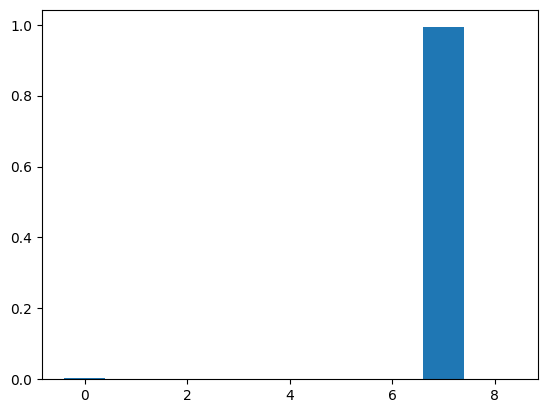

In [11]:
ttt = TicTacToe()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

state = ttt.get_initial_state()
state = ttt.get_next_state(state, 2, -1)
state = ttt.get_next_state(state, 4, -1)
state = ttt.get_next_state(state, 6, 1)
state = ttt.get_next_state(state, 8, 1)

encoded_state = ttt.get_encoded_state(state)

display(state)
display(encoded_state)
 
tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(ttt, 4, 64, device=device)
model.load_state_dict(torch.load('model_2.pt'))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value, policy)

plt.bar(range(ttt.action_size), policy)
plt.show()

In [12]:
class Node: 
    def __init__(self, game: TicTacToe, args, state, parent=None, action_taken=None, prior=0, visit_count = 0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
    
        self.visit_count = 0
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * np.sqrt((self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)
        
                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child) 
    

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        
        if self.parent is not None:
            self.parent.backpropagate(value)
            
        
            
class AMCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
        
    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)
        
        policy, value = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        
        # We add dirichlet noice to encourage exploration
        policy = (1- self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        
        policy /= np.sum(policy)
        
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
            
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)       
        
            node.backpropagate(value)
        
    
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
            
        action_probs /= np.sum(action_probs)
        
        return action_probs

        
        #return visit_counts

In [13]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = AMCTS(game, args, model)
    
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)
             
            memory.append((neutral_state, action_probs, player))
             
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            
            #Re-normalization
            temperature_action_probs /= np.sum(temperature_action_probs)
             
            action = np.random.choice(self.game.action_size, p=temperature_action_probs)
             
            state = self.game.get_next_state(state, action, player)
             
            value, is_terminal = self.game.get_value_and_terminated(state, action)
             
            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    
                    returnMemory.append(
                        (self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player)
                 
    
    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample) # list for each instead of list of tuples
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            #Now we turn it to tensors
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            # For the policy loss we use multi-target cross entropy
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            # We optimize the loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def learn(self):
        for iteration in trange(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()
            
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}_{self.game}.pt")

In [15]:
torch.cuda.is_available()

False

In [20]:
# Only run this to train the model
ttt = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ResNet(ttt, 4, 64, device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2, 
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.30
}

alphaZero = AlphaZero(model, optimizer, ttt, args)
alphaZero.learn()

cpu


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 2.0,
    'num_searches': 1000
}

model = ResNet(tictactoe, 4, 64)
model.eval()

mcts = AMCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()

while True:
    print(state)
    
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}"))
    
        if valid_moves[action] == 0:
            print("action not valid")
            continue
    
    else: 
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
    
    state = tictactoe.get_next_state(state, action, player)
    
    value, is_terminal = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
    
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]


[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
[[ 0.  0. -1.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]]
valid_moves [0, 1, 3, 4, 6, 7, 8]
[[ 0.  0. -1.]
 [ 0.  1.  1.]
 [ 0.  0.  0.]]
[[ 0.  0. -1.]
 [-1.  1.  1.]
 [ 0.  0.  0.]]
valid_moves [0, 1, 6, 7, 8]
[[ 0.  0. -1.]
 [-1.  1.  1.]
 [ 0.  1.  0.]]
[[ 0. -1. -1.]
 [-1.  1.  1.]
 [ 0.  1.  0.]]
valid_moves [0, 6, 8]
[[ 1. -1. -1.]
 [-1.  1.  1.]
 [ 0.  1.  0.]]
[[ 1. -1. -1.]
 [-1.  1.  1.]
 [ 0.  1. -1.]]
valid_moves [6]
action not valid
[[ 1. -1. -1.]
 [-1.  1.  1.]
 [ 0.  1. -1.]]
valid_moves [6]
[[ 1. -1. -1.]
 [-1.  1.  1.]
 [ 1.  1. -1.]]
draw
